## A standard suite of tools to work with $SPRUCE$ measurements

- let's get some satellite imagery figured out with `rasterio`
- `astropy` will give appropriate motions of the sun; use the clinometer to get altitude

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime as dt
from scipy import signal
import os
import struct
import wave

import sys
sys.path.append('/home/dax/PythonScripts/3_GITHUB/iyore')
import iyore

def parse_SPRUCE(meas, start_time, tree):
    
    '''
    Load a raw .CSV file
    '''
    
    SPRUCE = pd.read_csv(meas, header=None) # read in the raw .CSV file
    SPRUCE.columns = ["ch1", "ch2", "ch3", "loop length (ms)"] # give the columns meaningful names
    SPRUCE = SPRUCE.replace(' NULL', np.NaN) # convert 'NULL' strings to numeric NaN
    SPRUCE["loop length (ms)"] = SPRUCE["loop length (ms)"].str[:-1] # strip trailing semicolon
    SPRUCE = SPRUCE.astype('float') # cooerce to floating point numbers

    # a meaningful datetime index
    SPRUCE.index = start_time + (SPRUCE["loop length (ms)"].cumsum()/1000).apply(lambda t: dt.timedelta(seconds=t))
    
    SPRUCE["tree"] = tree
    
    SPRUCE.name = tree

    return SPRUCE

def signal_to_wav(signal, fname, Fs):
    
    """Convert a numpy array into a wav file.

     Args
     ----
     signal : 1-D numpy array
         An array containing the audio signal.
     fname : str
         Name of the audio file where the signal will be saved.
     Fs: int
        Sampling rate of the signal.

    """
    data = struct.pack('<' + ('h'*len(signal)), *signal)
    wav_file = wave.open(fname, 'wb')
    wav_file.setnchannels(1)
    wav_file.setsampwidth(2)
    wav_file.setframerate(Fs)
    wav_file.writeframes(data)
    wav_file.close()
    
    print("complete.")

### <font color="salmon"> Load a single measurement </font>
<font color="salmon"> **Sometimes this is the right choice, but not usually.** </font>

In [6]:
# meas = '/home/dax/Documents/ALBUM/Spruce/Field Testing/Measurements/2022 06 13/00000.CSV'
# meas = '/home/dax/Documents/ALBUM/SPRUCE/Field Testing/Measurements/2022 06 18/Brushkana_001/00000.CSV'
# meas = '/home/dax/Documents/ALBUM/SPRUCE/Field Testing/Measurements/2022 06 18/Brushkana_003/00000.CSV'
# meas = '/home/dax/Documents/ALBUM/SPRUCE/Field Testing/Measurements/2022 06 18/Brushkana_003/10000.CSV'
# meas = '/home/dax/Documents/ALBUM/SPRUCE/Field Measurements/2022 06 19/BlueHome_002/10000.CSV'
# meas = "/home/dax/Documents/ALBUM/SPRUCE/Field Measurements/2022 07 12/DenaliHQ_001/11100.CSV"
# meas = '/home/dax/Documents/ALBUM/SPRUCE/Field Measurements/2022 07 30/BlueHome_001/00000.CSV'
# meas = '/home/dax/Documents/ALBUM/SPRUCE/Field Measurements/2022 08 01/CantwellRock_001/00011_20220801_204500.CSV'
meas = '/home/dax/Documents/ALBUM/SPRUCE/Field Measurements/2022 08 16/CantwellRock_001/11111_20220816_203700.CSV'
start_time = dt.datetime(2022, 8, 16, 20, 37, 0)
tree = "Cantwell Rock 001"

S = parse_SPRUCE(meas, start_time, tree)
S

,ch1,ch2,ch3,loop length (ms)
loop length (ms),,,,
2022-08-16 20:37:00.235,-0.0791,0.0421,0.0195,235.0
2022-08-16 20:37:00.420,-0.0849,0.0375,0.0009,185.0
2022-08-16 20:37:00.604,-0.0859,0.0375,0.0011,184.0
2022-08-16 20:37:00.787,-0.0867,0.0384,0.0012,183.0
2022-08-16 20:37:00.972,-0.0859,0.0382,0.0007,185.0
...,...,...,...,...
2022-08-21 20:14:08.446,-0.0513,0.0360,0.0075,184.0
2022-08-21 20:14:08.629,-0.0513,0.0364,0.0105,183.0
2022-08-21 20:14:08.814,-0.0515,0.0358,0.0119,185.0


## Load *every* measurement
Usually this is what you want!

In [18]:
SPRUCE = iyore.Dataset(r"/home/dax/Documents/ALBUM/SPRUCE/Field Measurements")

# join all spruce measurements together
S = pd.concat([parse_SPRUCE(e.path,
                        dt.datetime(int(e.year), 
                                    int(e.month), 
                                    int(e.day), 
                                    int(e.begin_hour), 
                                    int(e.begin_minute)),
                                    e.location + " " + e.num) for e in SPRUCE.meas()])


# # S.index = np.arange(len(S))

# trim off the rather extreme bits
S.loc[:, "ch1":"ch3"] = S.loc[:, "ch1":"ch3"].mask(S.loc[:, "ch1":"ch3"].abs() > 0.2)

# start_time = dt.datetime.now()
# S.index = start_time + (S["loop length (ms)"].cumsum()/1000).apply(lambda t: dt.timedelta(seconds=t))


S = S.sort_index()
S

,ch1,ch2,ch3,loop length (ms),tree
loop length (ms),,,,,
2022-06-07 19:15:00.170,NaN,NaN,0.1526,170.0,BlueHome 003
2022-06-07 19:15:00.293,NaN,NaN,0.1503,123.0,BlueHome 003
2022-06-07 19:15:00.418,NaN,NaN,0.1530,125.0,BlueHome 003
2022-06-07 19:15:00.543,NaN,NaN,0.1548,125.0,BlueHome 003
2022-06-07 19:15:00.667,NaN,NaN,0.1557,124.0,BlueHome 003
...,...,...,...,...,...
2022-08-23 23:45:58.557,-0.0671,0.0889,-0.0218,186.0,CantwellRock 001
2022-08-23 23:45:58.741,-0.0671,0.0895,-0.0215,184.0,CantwellRock 001
2022-08-23 23:45:58.925,-0.0660,0.0882,-0.0230,184.0,CantwellRock 001


In [17]:
# (6.2*1000)/(S.index.max() - S.index.min()).seconds

# 0.2 # kB/s
# # dt.timedelta(days=5)

# (128*1000/0.2)/(24*3600)

7.407407407407407

In [19]:
%store -r time_series

In [20]:
time_series

,geometry,"t, 2m"
2022-05-01 00:00:00,POINT (-148.97583 63.39639),-0.658356
2022-05-01 03:00:00,POINT (-148.97583 63.39639),-1.379059
2022-05-01 06:00:00,POINT (-148.97583 63.39639),-0.852570
2022-05-01 09:00:00,POINT (-148.97583 63.39639),1.720673
2022-05-01 12:00:00,POINT (-148.97583 63.39639),4.614960
...,...,...
2022-08-28 06:00:00,POINT (-148.97583 63.39639),6.558441
2022-08-28 09:00:00,POINT (-148.97583 63.39639),9.825043
2022-08-28 12:00:00,POINT (-148.97583 63.39639),11.620270
2022-08-28 15:00:00,POINT (-148.97583 63.39639),11.414337


In [28]:
dir_dict = {"ch2":12, "ch3":140, "ch1":285}

In [22]:
print("interior angles", "\n\n", 
      "from 1 to 2:", str((360-285)+12)+"°\n",
      "from 2 to 3:", str(140-12)+"°\n",
      "from 3 to 1:", str(285-140)+"°\n")

print(87+128+145)

interior angles 

 from 1 to 2: 87°
 from 2 to 3: 128°
 from 3 to 1: 145°

360


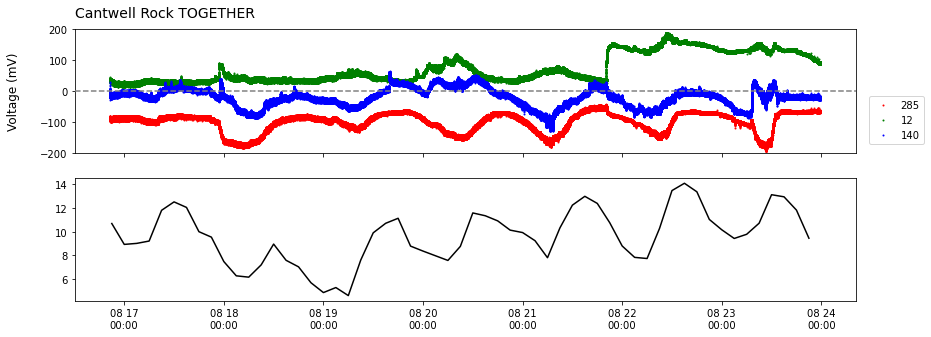

In [24]:
# title = dt.datetime.strftime(S.index.min(), "%Y %m %d") + " " + "ALL"
# title = "ALL MEASUREMENTS TOGETHER"

S = S.loc[S["tree"] == 'CantwellRock 001']
S = S.loc["2022-08-16 12:00:00":, :]
title = "Cantwell Rock TOGETHER"
linesPerSave = 250

fig, ax = plt.subplots(2, 1, figsize=(14, 5), sharex=True)
ax[0].plot(S.index, 1000*S["ch1"], 
           color="red", ls="", marker="o", ms=1, label=dir_dict["ch1"])
ax[0].plot(S.index, 1000*S["ch2"], 
           color="green", ls="", marker="o", ms=1, label=dir_dict["ch2"])
ax[0].plot(S.index, 1000*S["ch3"], 
           color="blue", ls="", marker="o", ms=1, label=dir_dict["ch3"])
ax[0].set_title(title, fontsize=14, loc="left", y=1.05)

ax[0].set_ylabel("Voltage (mV)", labelpad=20, fontsize=12)
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%m %d\n%H:%M"))

ax[0].axhline(0, ls="--", color="gray", zorder=20)

ax[0].legend(bbox_to_anchor=(1.01, 0.5))
ax[0].set_ylim(-200, 200)

time_series = time_series.loc[S.index.min():S.index.max()]
ax[1].plot(time_series.index, time_series["t, 2m"], 
           color="k", ls="-", label="temp C")

# # draw the 
# for i in np.arange(0, len(S), linesPerSave):
#     ax.axvline(S.iloc[i, :].name, color="red", ls="--", alpha=0.1, zorder=2)

# plt.savefig(r"/home/dax/Documents/ALBUM/Spruce/Field Testing" + os.sep + title + ".png",
#             dpi=150, bbox_inches="tight", facecolor="white")

# ax.set_xlim(S.index.min(), S.index.min()+dt.timedelta(minutes=20))


plt.show()

In [21]:
help(dt.datetime.replace)

Help on method_descriptor:

replace(...)
    Return datetime with new specified fields.



In [46]:
S.index.max()

Timestamp('2022-08-23 23:45:59')

In [25]:
# start_clip = "2022-08-17 00:00:00"
# plt.plot(S.loc[start_clip:, "ch1"], time_series[start_clip:])

S.index = S.index.to_series().apply(lambda t: t.replace(microsecond=0))

J = time_series.merge(S, how="inner", left_index=True, right_index=True)
J

,geometry,"t, 2m",ch1,ch2,ch3,loop length (ms),tree
2022-08-16 21:00:00,POINT (-148.97583 63.39639),10.701355,-0.0896,0.0267,-0.0148,184.0,CantwellRock 001
2022-08-16 21:00:00,POINT (-148.97583 63.39639),10.701355,-0.0897,0.0269,-0.0127,185.0,CantwellRock 001
2022-08-16 21:00:00,POINT (-148.97583 63.39639),10.701355,-0.0913,0.0275,-0.0153,185.0,CantwellRock 001
2022-08-16 21:00:00,POINT (-148.97583 63.39639),10.701355,-0.0893,0.0278,-0.0145,184.0,CantwellRock 001
2022-08-16 21:00:00,POINT (-148.97583 63.39639),10.701355,-0.0903,0.0278,-0.0124,185.0,CantwellRock 001
...,...,...,...,...,...,...,...
2022-08-23 21:00:00,POINT (-148.97583 63.39639),9.458862,-0.0692,0.1146,-0.0205,184.0,CantwellRock 001
2022-08-23 21:00:00,POINT (-148.97583 63.39639),9.458862,-0.0681,0.1137,-0.0190,184.0,CantwellRock 001
2022-08-23 21:00:00,POINT (-148.97583 63.39639),9.458862,-0.0680,0.1136,-0.0241,185.0,CantwellRock 001
2022-08-23 21:00:00,POINT (-148.97583 63.39639),9.458862,-0.0678,0.1141,-0.0210,185.0,CantwellRock 001


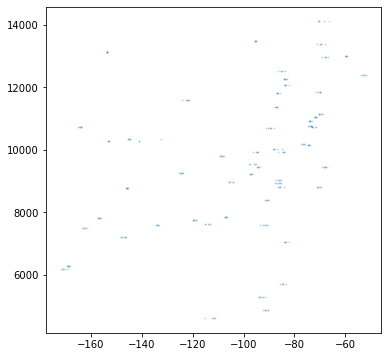

In [26]:
plt.figure(figsize=(6, 6))
plt.plot(1000*J["ch1"], 
         1000*J["t, 2m"], 
         ls="", ms=1, marker="o", alpha=0.2)
plt.show()

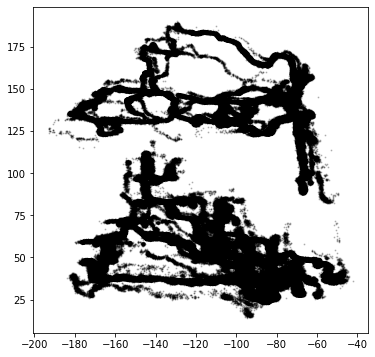

In [27]:
start_clip = "2022-08-17 00:00:00"
plt.figure(figsize=(6, 6))
plt.plot(1000*S.loc[start_clip:, "ch1"], 
         1000*S.loc[start_clip:, "ch2"], 
         ls="", ms=1, marker="o", color="k", alpha=0.2)
plt.show()

/tmp/ipykernel_53411/1994571698.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hourly = np.array([(hr, np.nanpercentile(group.loc[:, ["ch1", "ch2", "ch3"]], 50, axis=0)) for hr, group in S.groupby("Hour")])


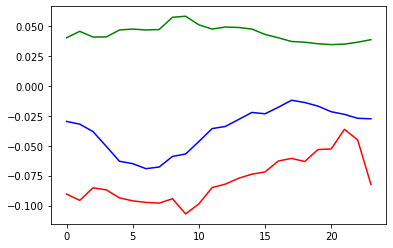

In [34]:
S["Hour"] = S.index.to_series().dt.hour

hourly = np.array([(hr, np.nanpercentile(group.loc[:, ["ch1", "ch2", "ch3"]], 50, axis=0)) for hr, group in S.groupby("Hour")])
hours, medians = hourly.T

channels = pd.DataFrame([list(p) for p in medians], columns=["ch1", "ch2", "ch3"])
plt.plot(channels.index.astype('int'), channels["ch1"], label="ch1", color="red")
plt.plot(channels.index.astype('int'), channels["ch2"], label="ch2", color="green")
plt.plot(channels.index.astype('int'), channels["ch3"], label="ch3", color="blue")
plt.show()

In [24]:
np.nanpercentile(S.loc[:, ["ch1", "ch2", "ch3"]], 50, axis=0)

array([-0.0748,  0.0402, -0.0377])

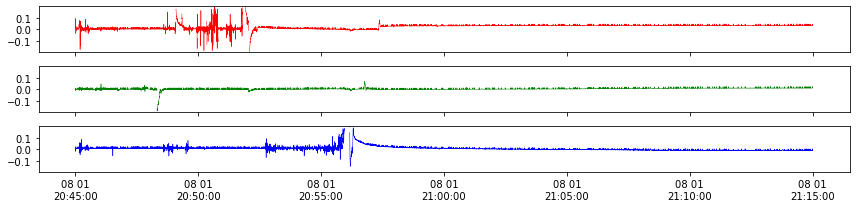

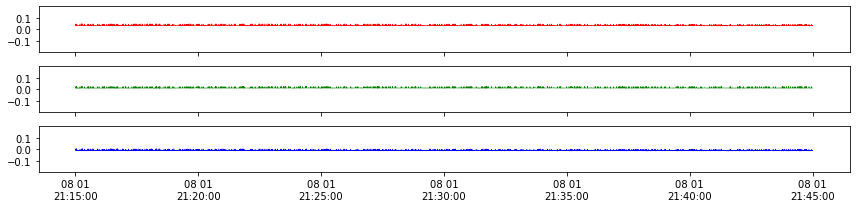

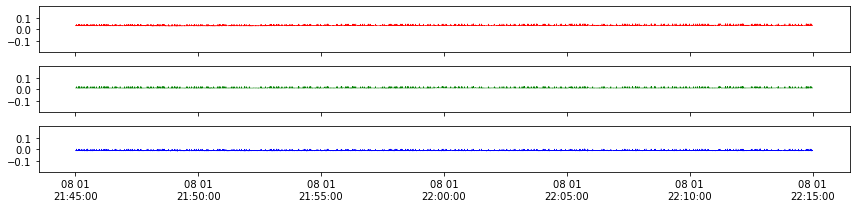

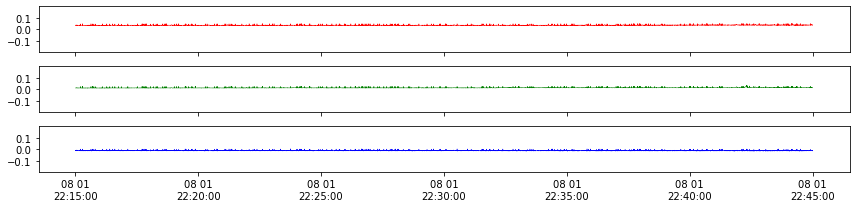

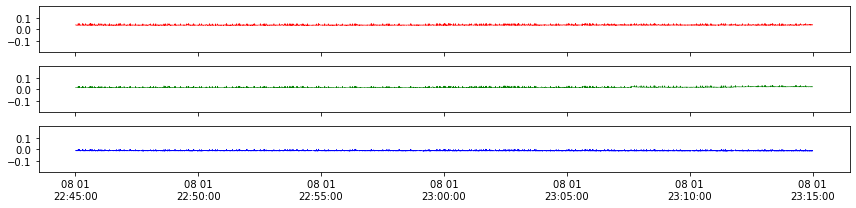

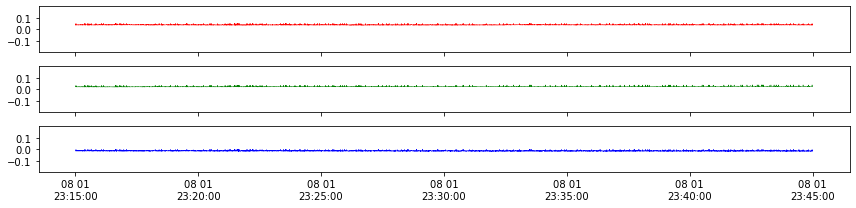

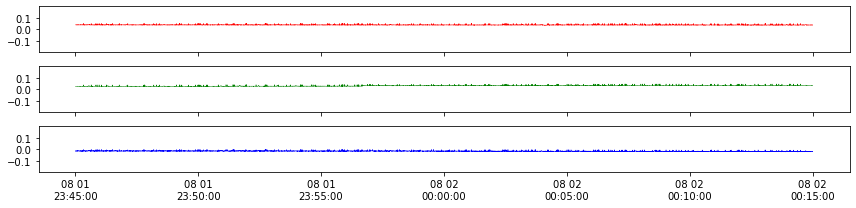

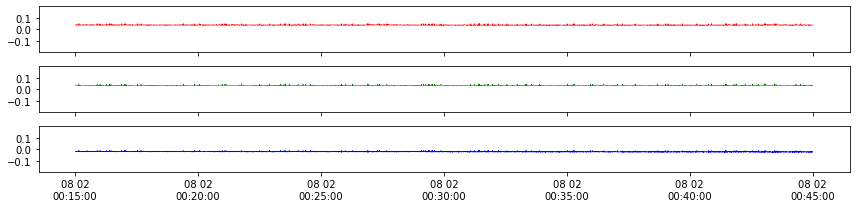

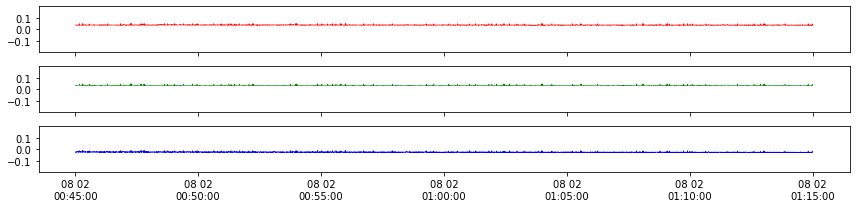

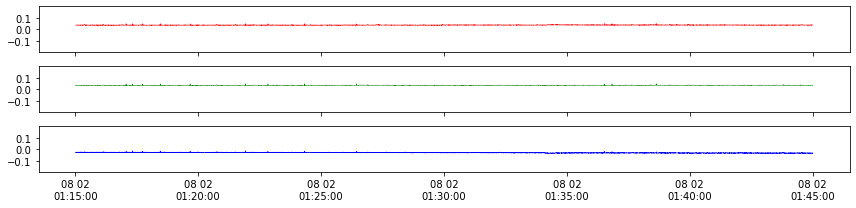

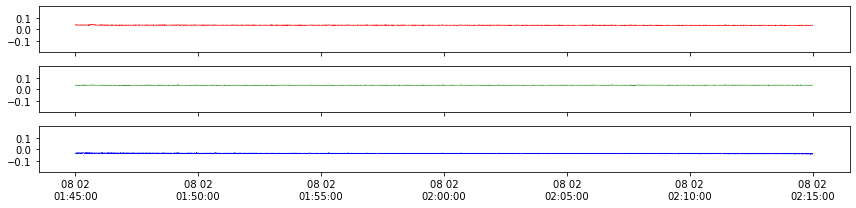

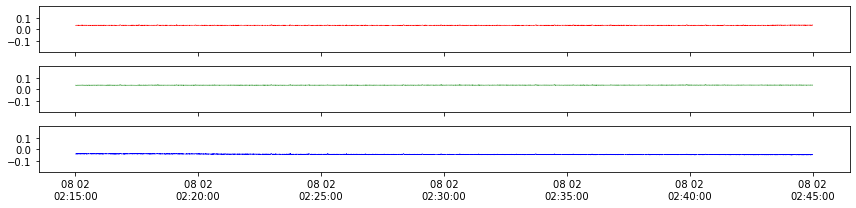

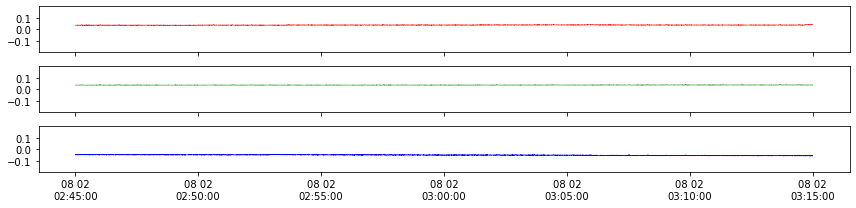

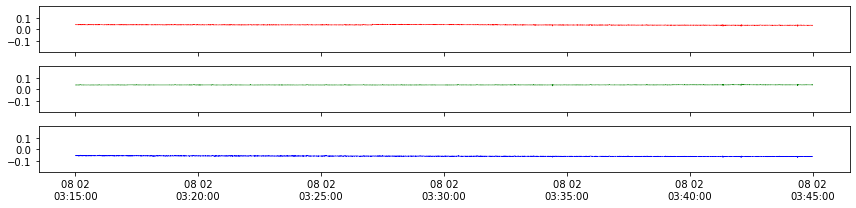

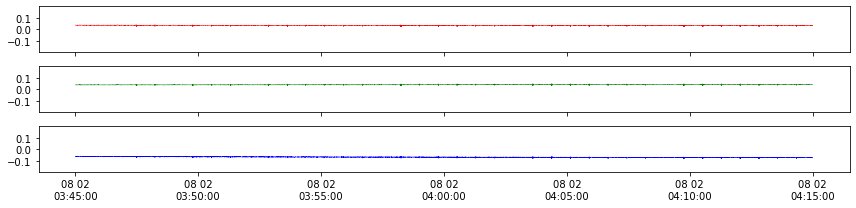

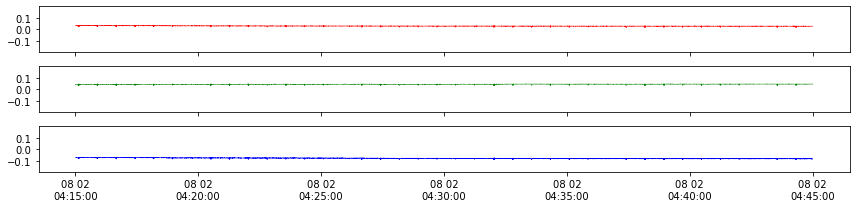

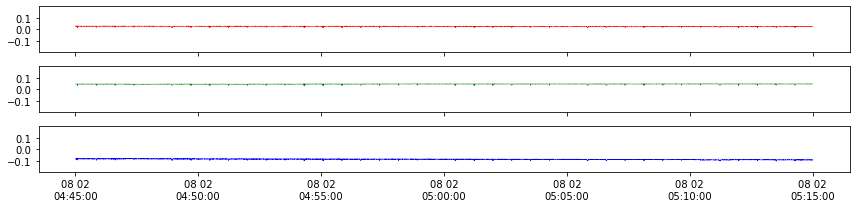

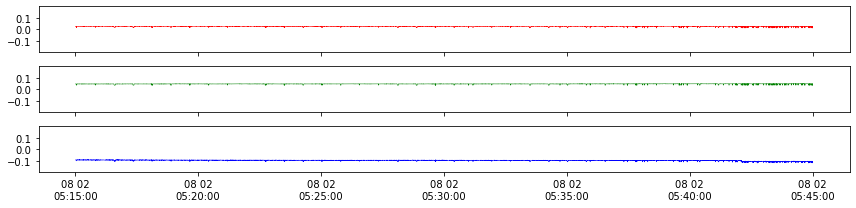

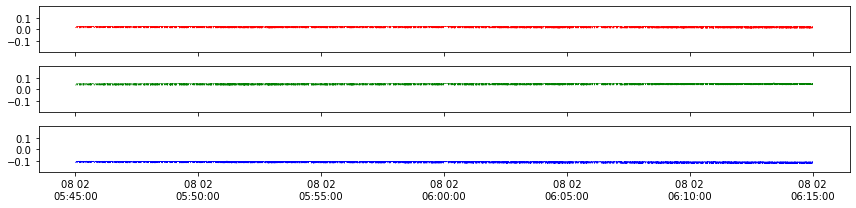

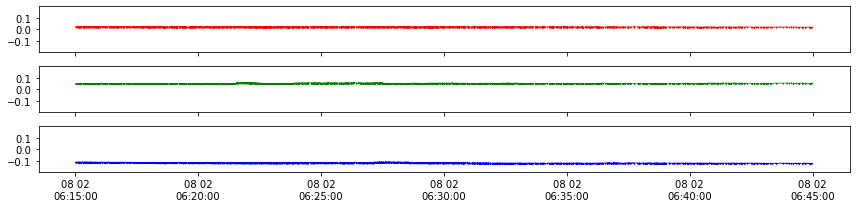

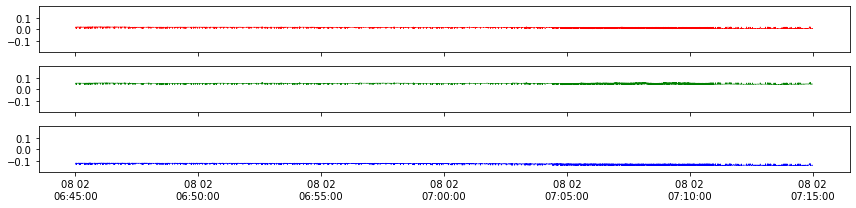

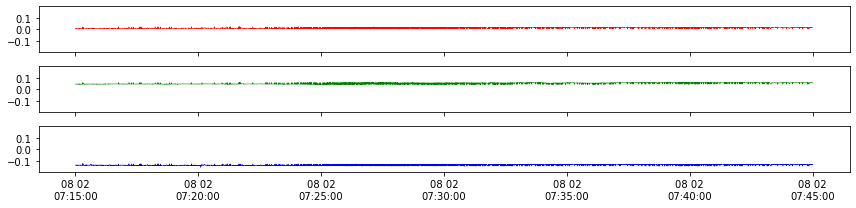

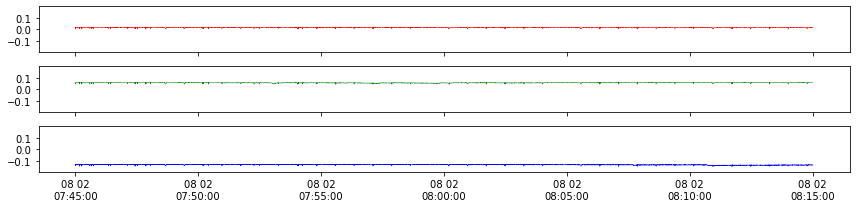

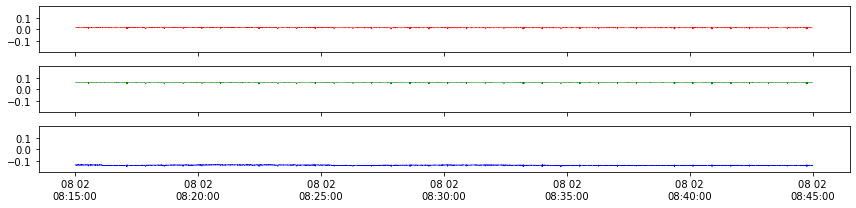

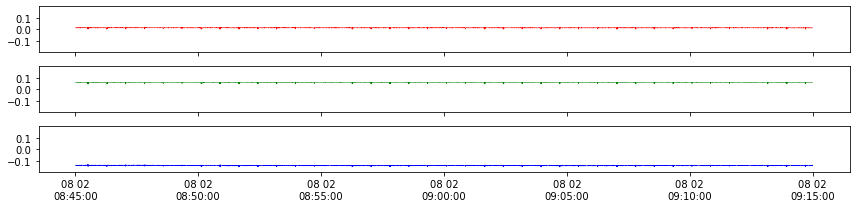

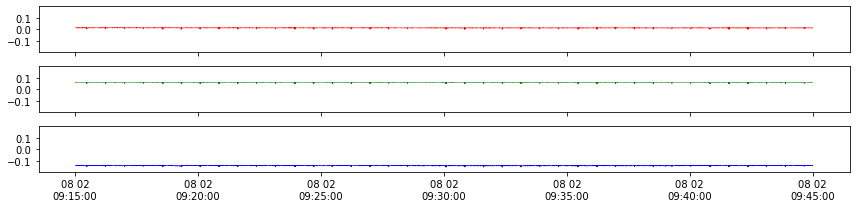

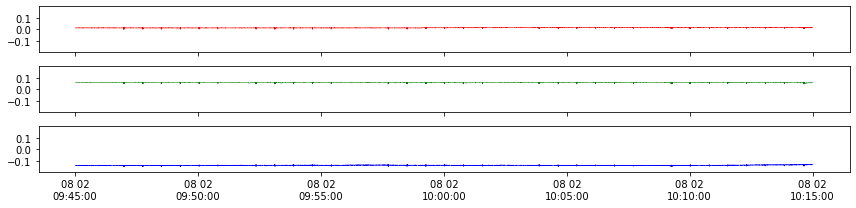

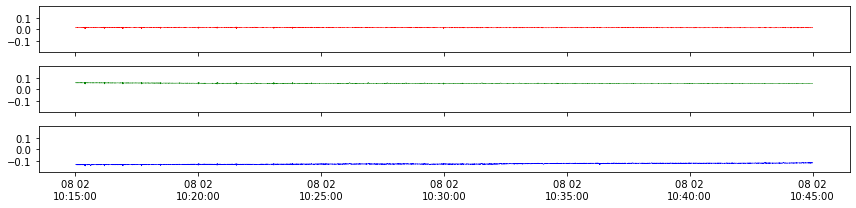

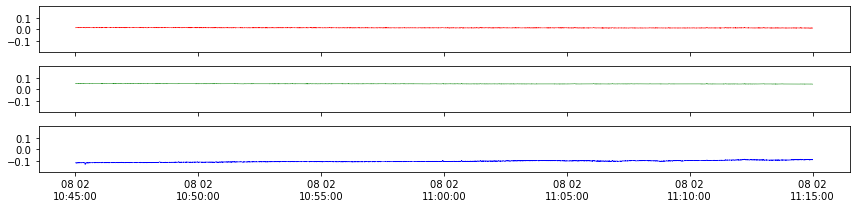

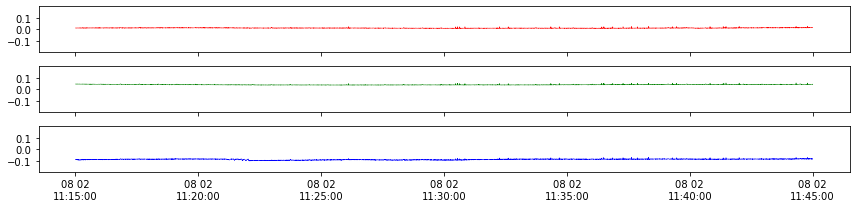

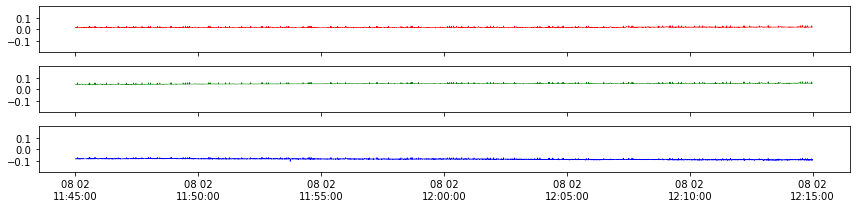

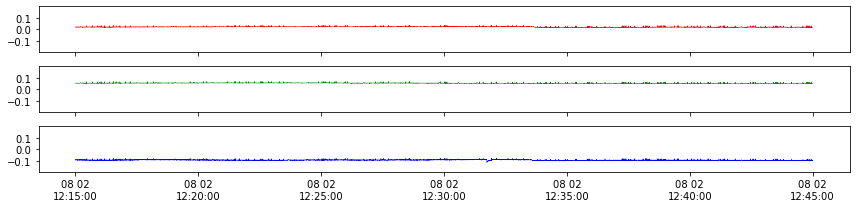

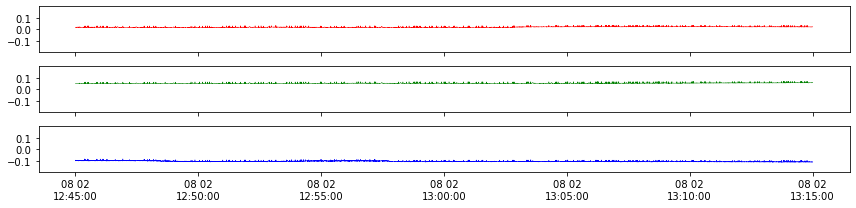

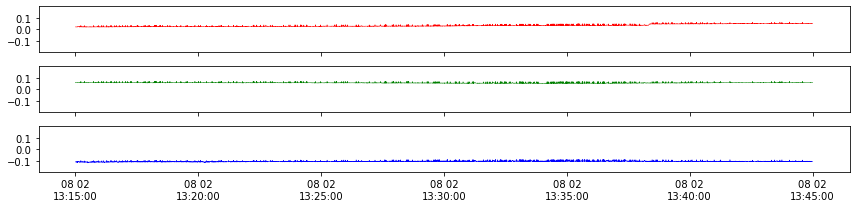

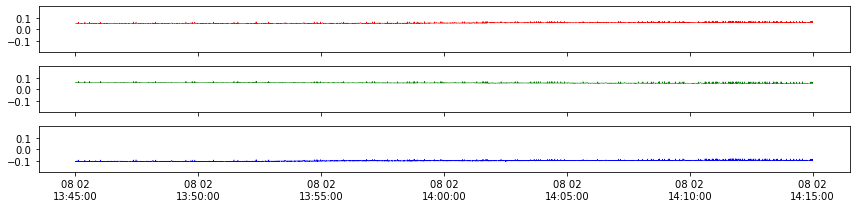

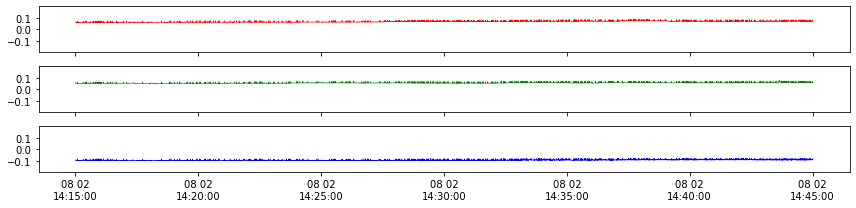

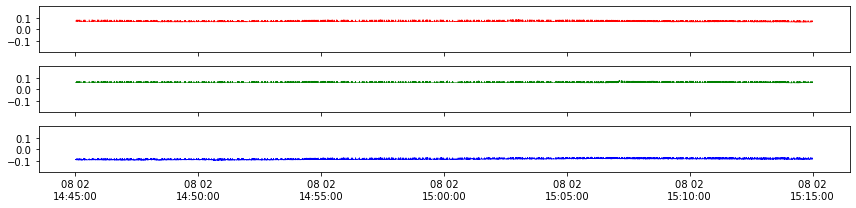

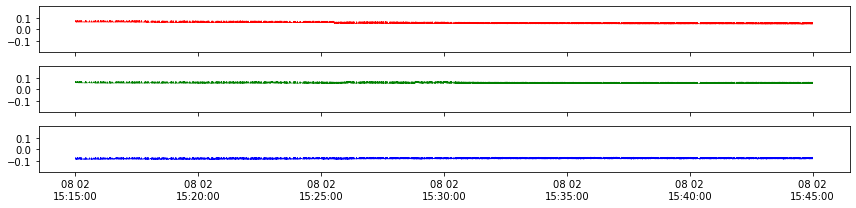

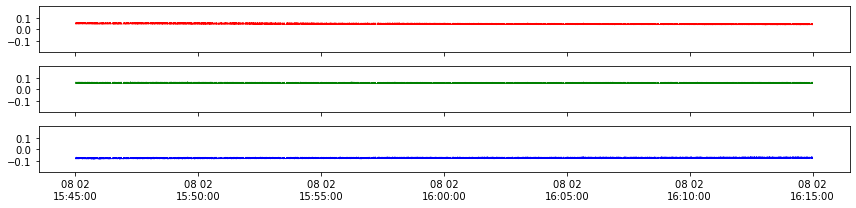

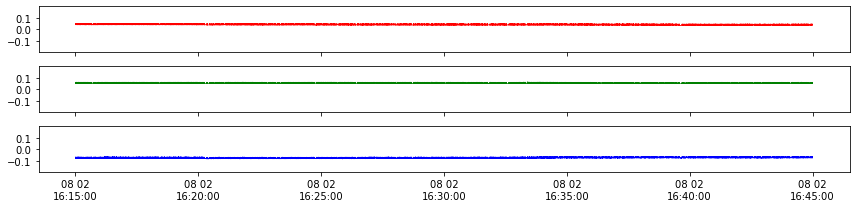

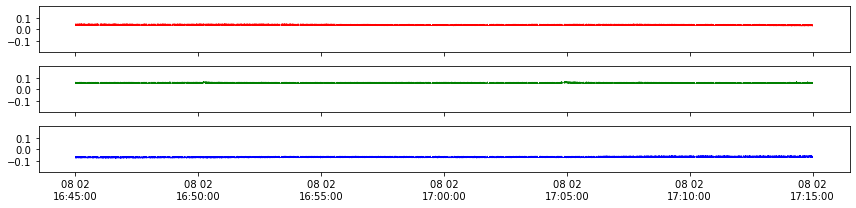

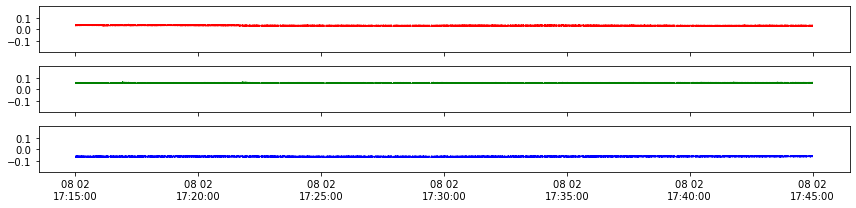

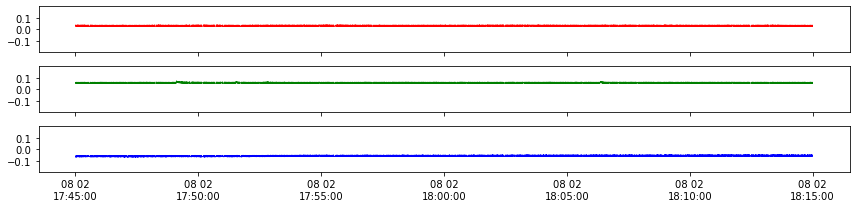

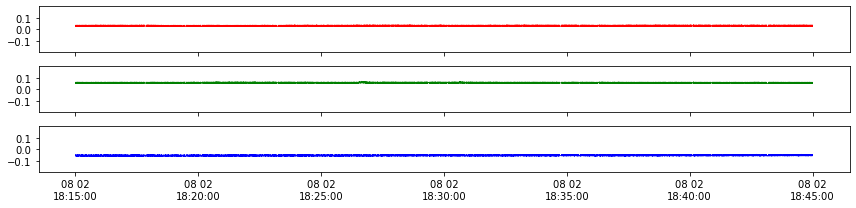

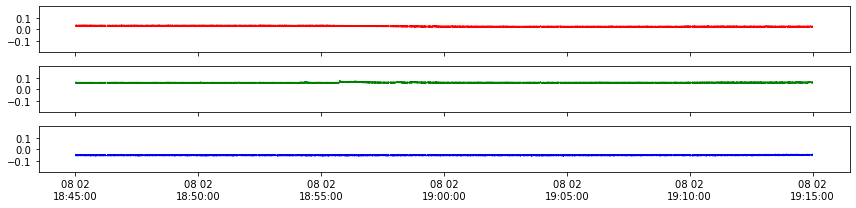

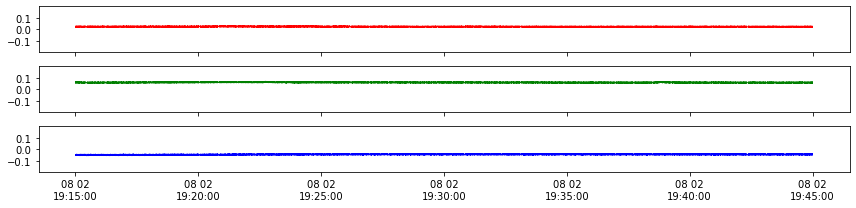

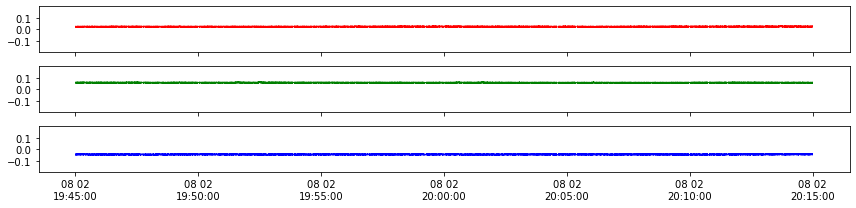

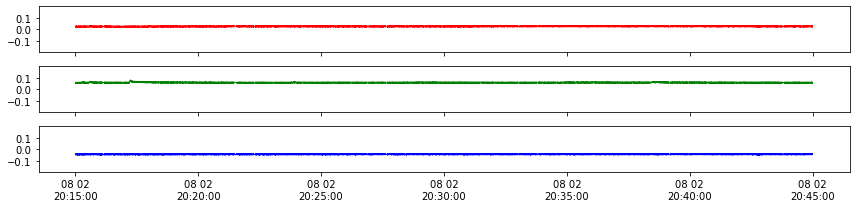

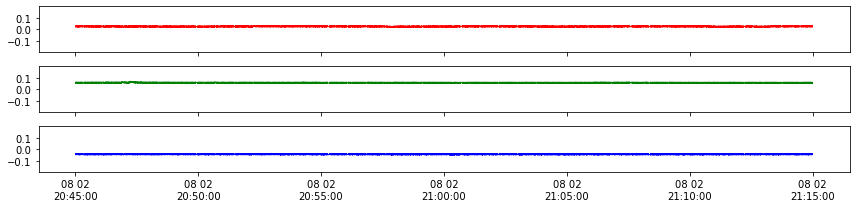

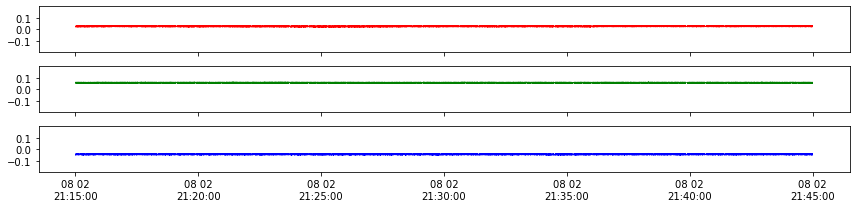

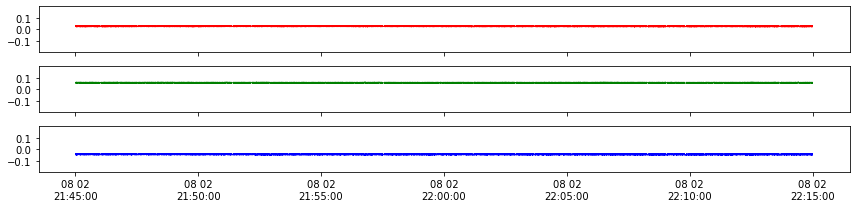

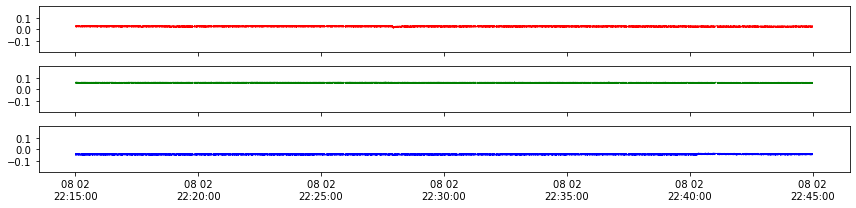

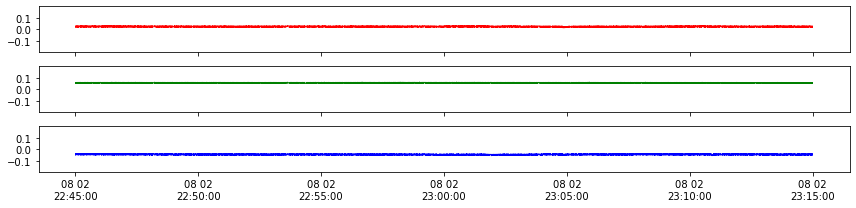

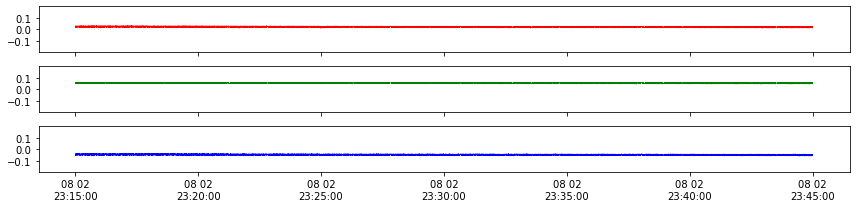

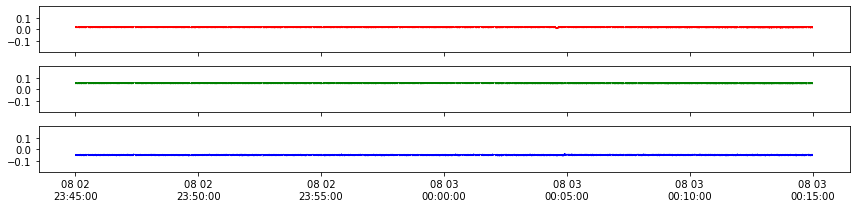

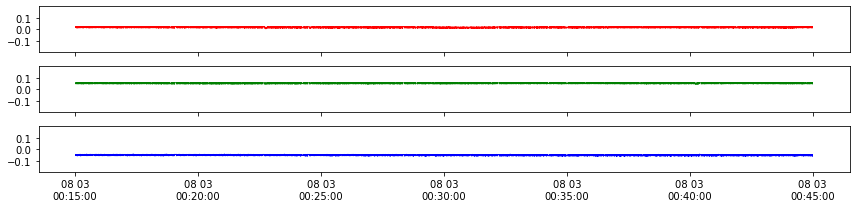

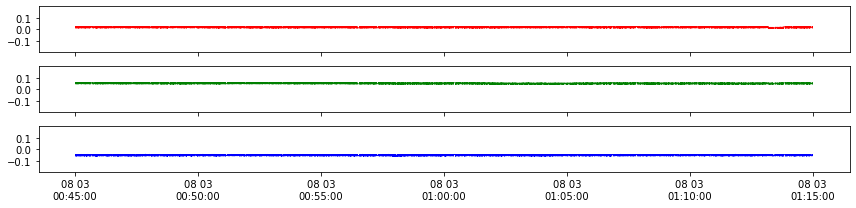

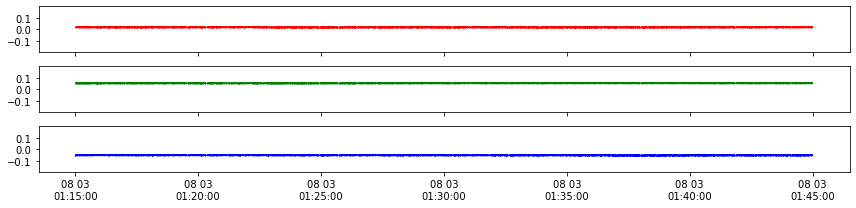

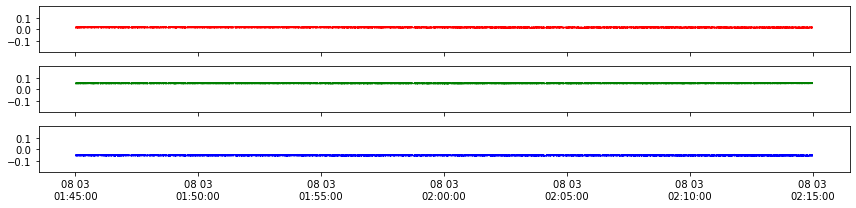

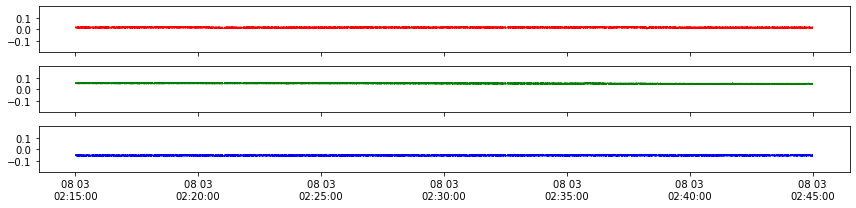

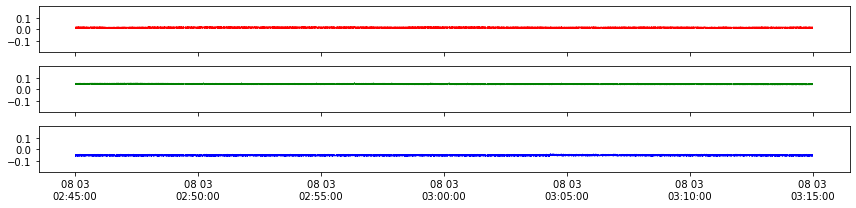

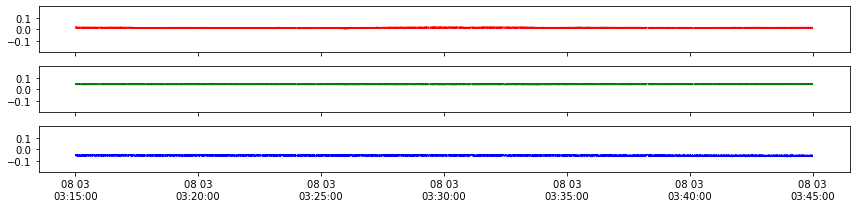

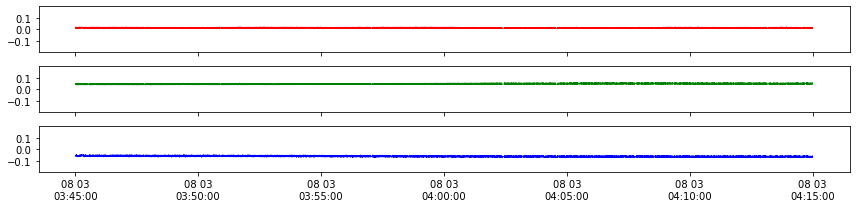

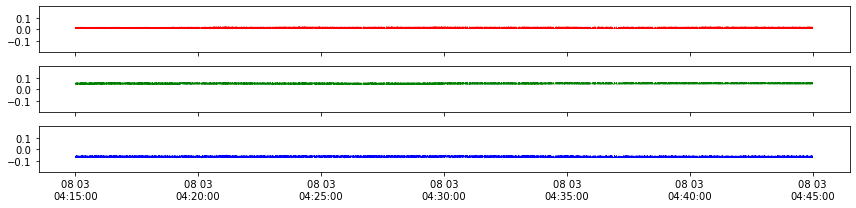

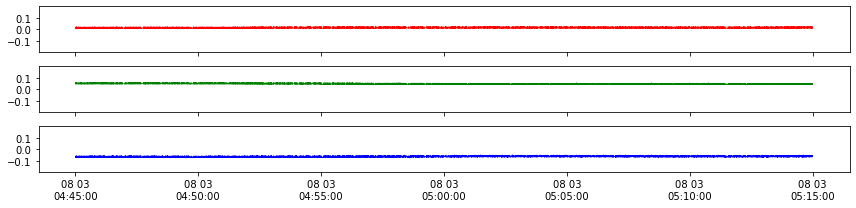

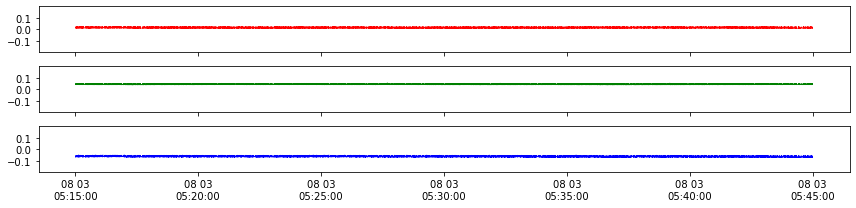

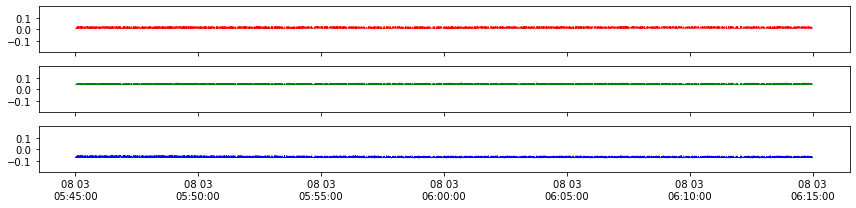

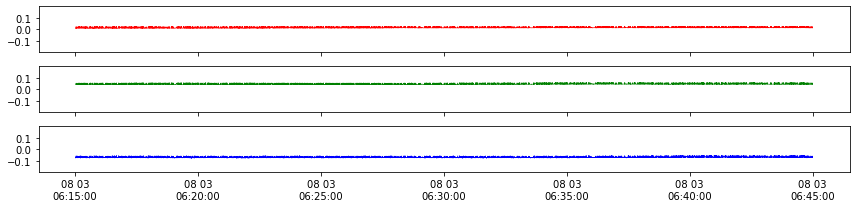

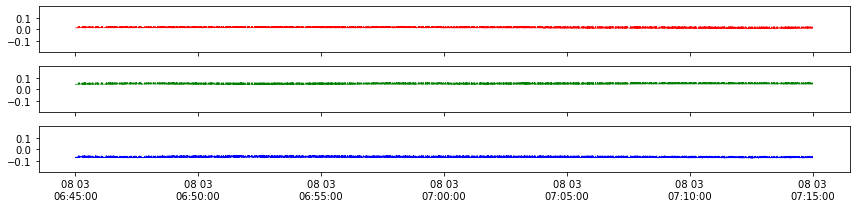

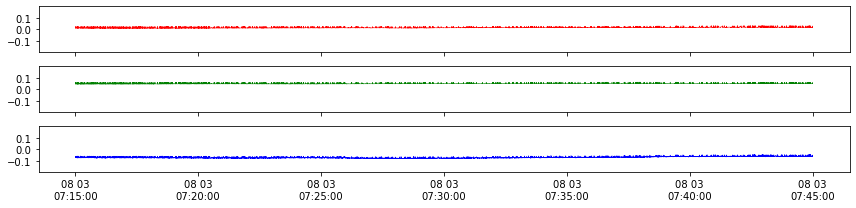

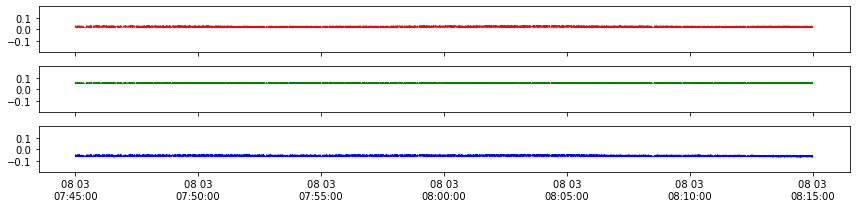

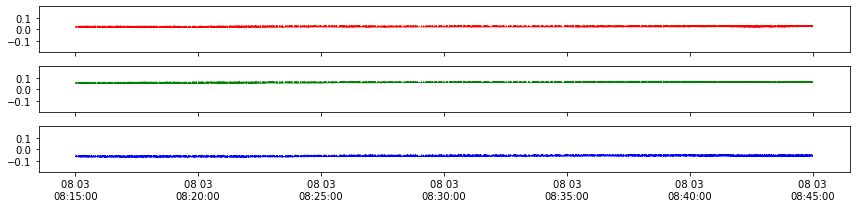

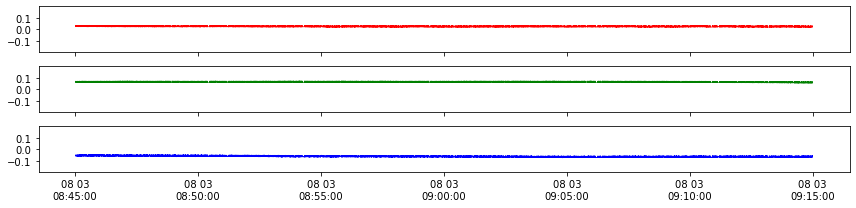

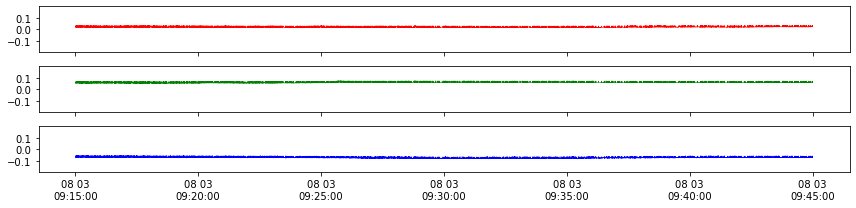

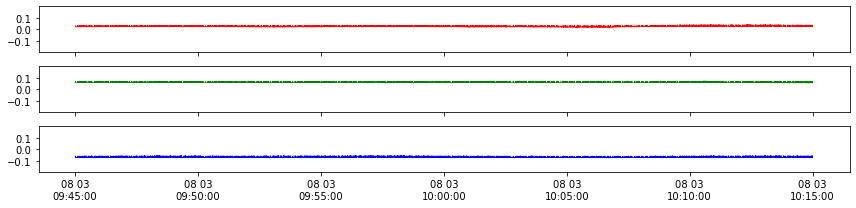

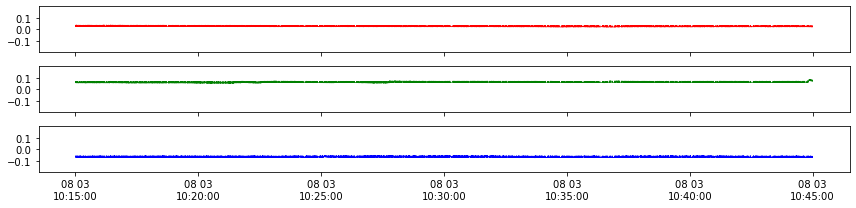

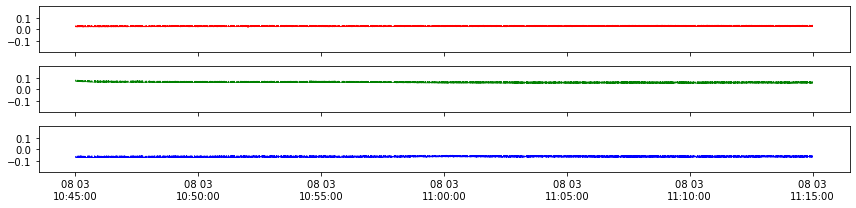

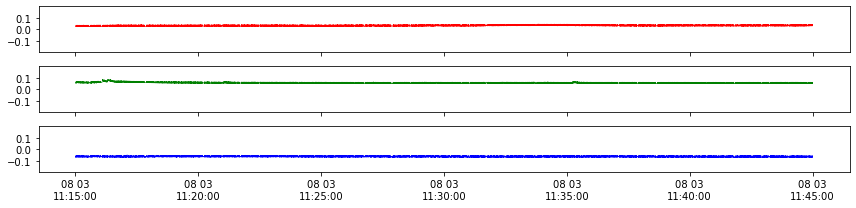

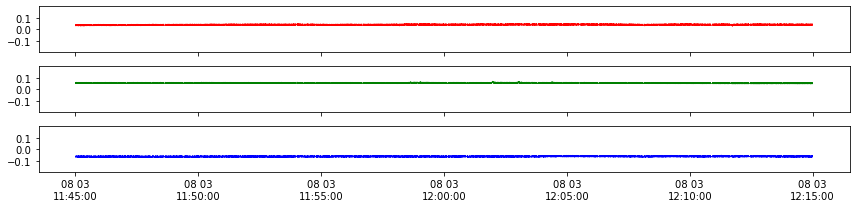

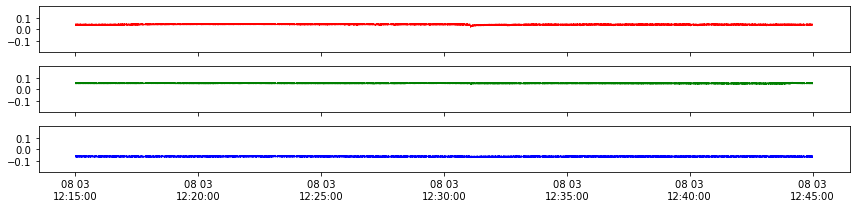

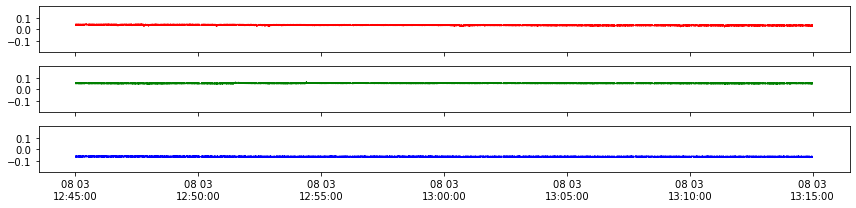

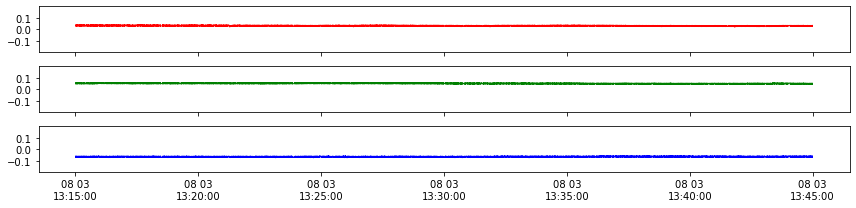

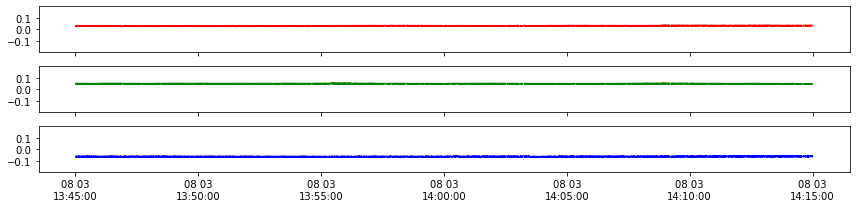

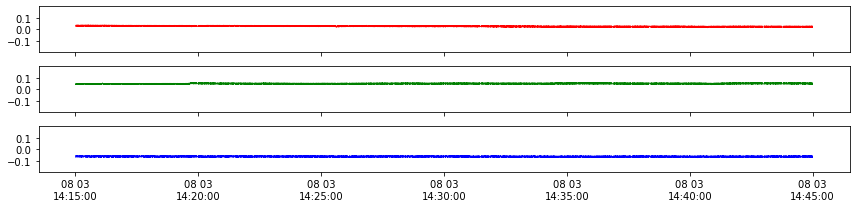

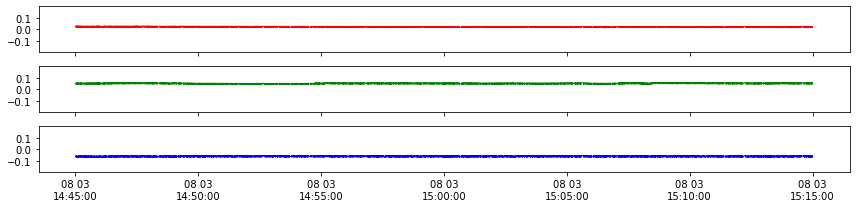

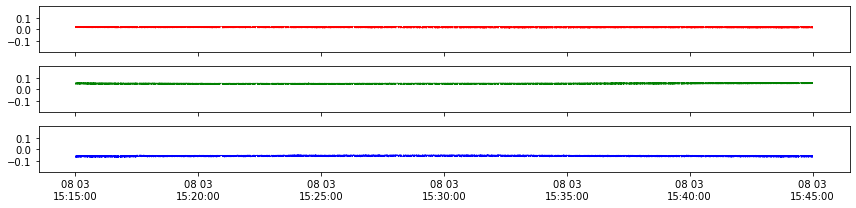

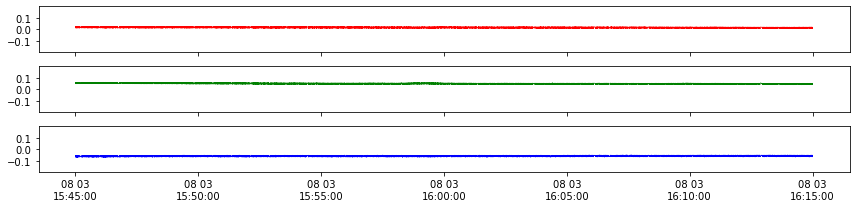

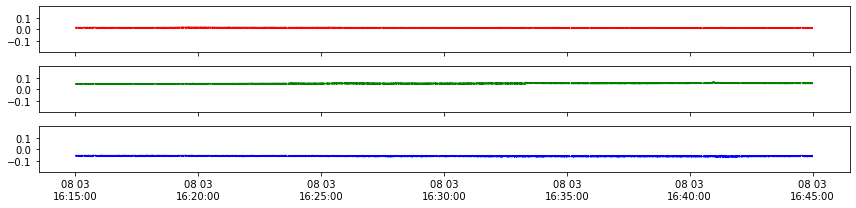

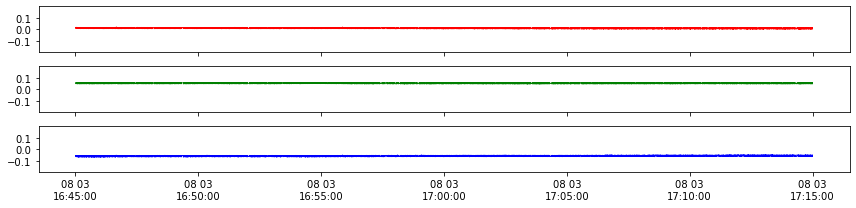

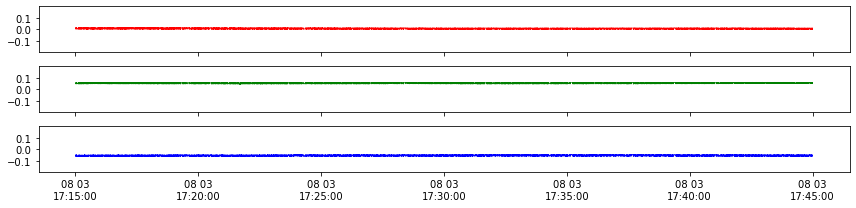

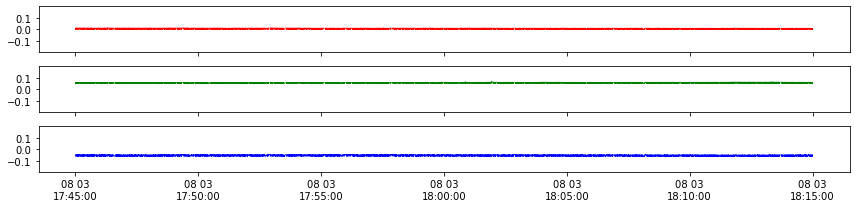

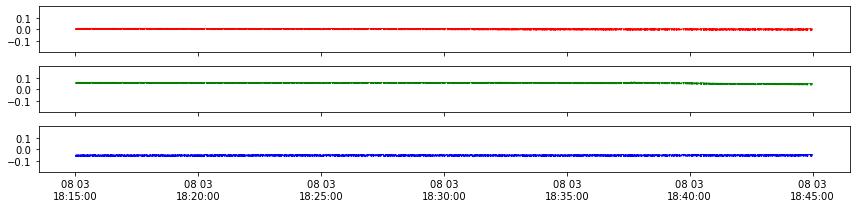

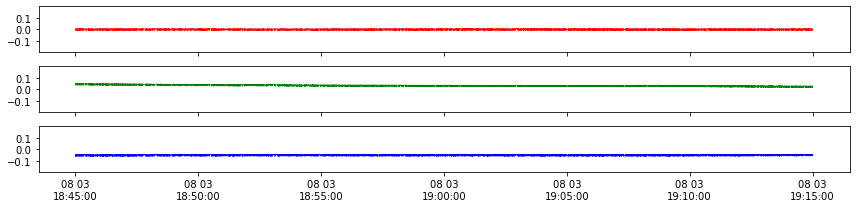

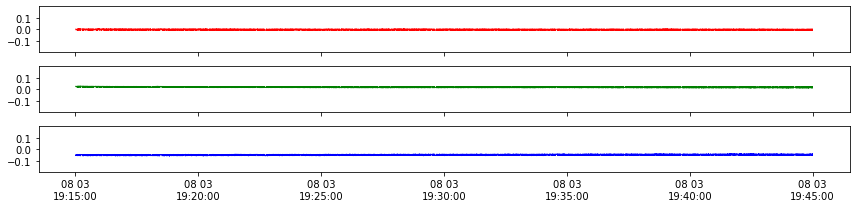

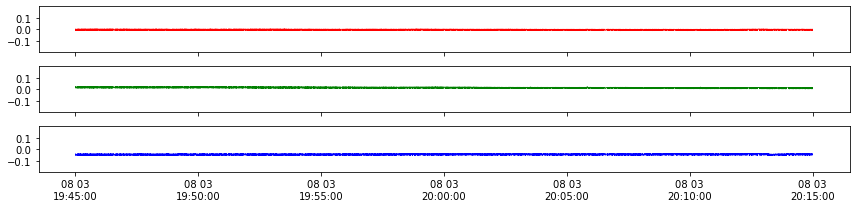

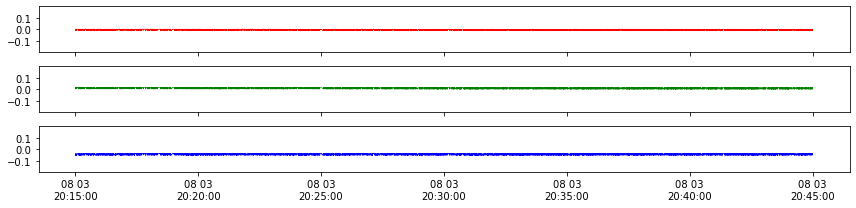

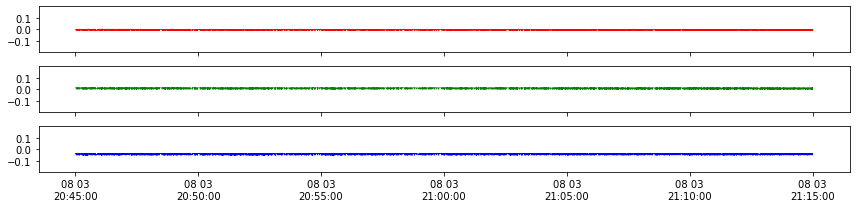

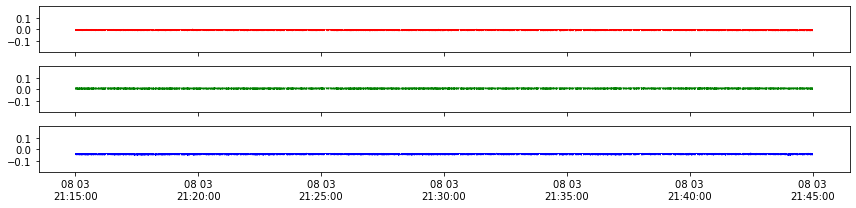

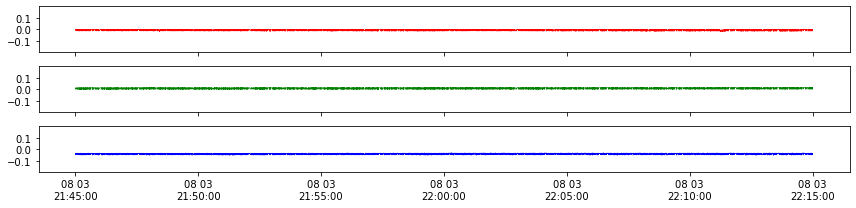

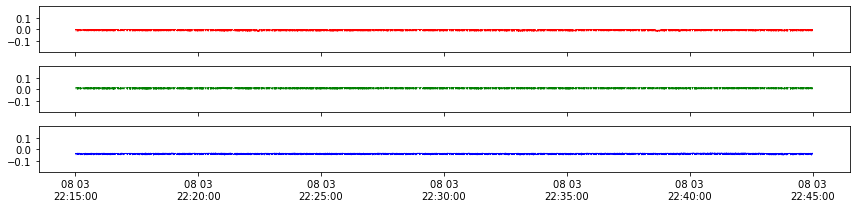

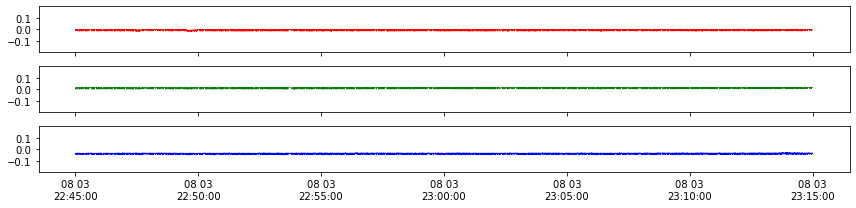

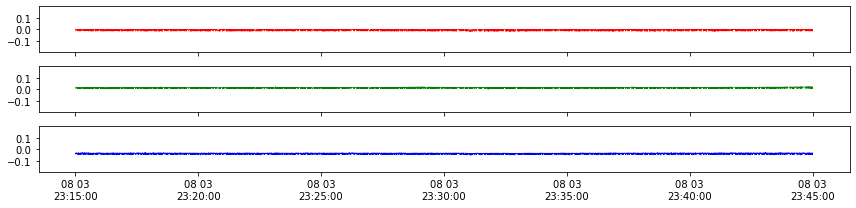

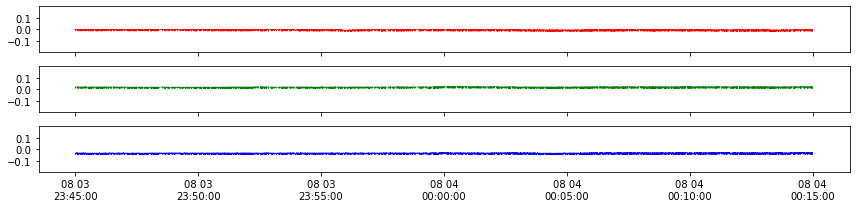

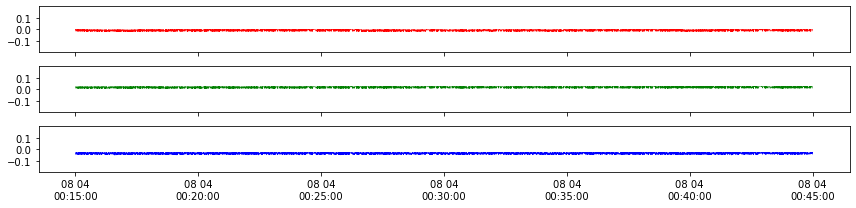

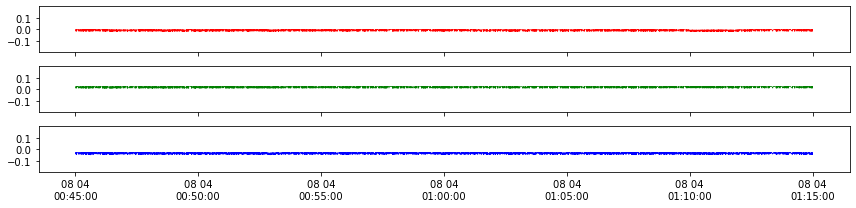

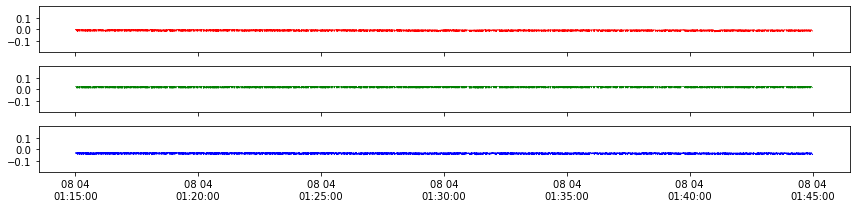

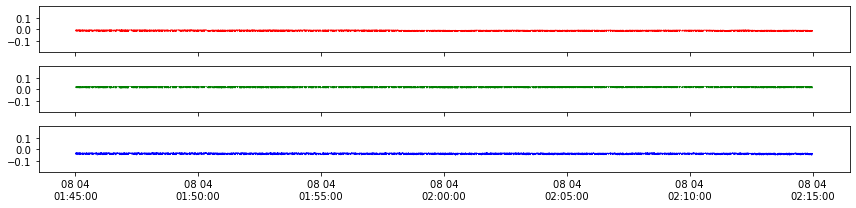


KeyboardInterrupt



In [35]:
step = 30 # mins
time_steps = np.arange(S.index.min(), S.index.max(), dt.timedelta(minutes=step))


for i, time_step in enumerate(time_steps):
    
    ts = pd.to_datetime(time_step)
    y_max = S.max()[:3].max()
#     y_max = 0.02
#     y_max = 0.1
    y_min = S.min()[:3].min()
#     y_min = 0.0
    
    fig, ax = plt.subplots(3, 1, figsize=(12, 3), sharex=True)
    ax[0].plot(S.loc[ts:ts+dt.timedelta(minutes=step), "ch1"], lw=0.5, color="red")
    ax[1].plot(S.loc[ts:ts+dt.timedelta(minutes=step), "ch2"], lw=0.5, color="green")
    ax[2].plot(S.loc[ts:ts+dt.timedelta(minutes=step), "ch3"], lw=0.5, color="blue")
    
    for a in ax:
        a.set_ylim([y_min, y_max])
        a.xaxis.set_major_formatter(mdates.DateFormatter("%m %d\n%H:%M:%S"))
        
    plt.tight_layout()
    plt.show()
    plt.close()

### A 3D plot

In [52]:


    print(tree)

BlueHome 001
BlueHome 002
BlueHome 003
Brushkana 001
Brushkana 003
CantwellRock 001
DenaliHQ 001


In [54]:
# for creating a responsive plot
# %matplotlib widget

%matplotlib qt

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
step = 50

color_dict = {"BlueHome 001":"blue", "BlueHome 002":"blue", "BlueHome 003":"navy",
              "Brushkana 001":"orange", "Brushkana 003":"salmon",
              "CantwellRock 001":"k", "DenaliHQ 001":"green"}

for tree, obs in S.groupby("tree"):

    ax.plot(obs["ch1"][::step], obs["ch2"][::step], obs["ch3"][::step], 
            color=color_dict[tree], ls="", ms=1, marker="o", alpha=0.5)
ax.view_init(elev=45, azim=30)
plt.show()

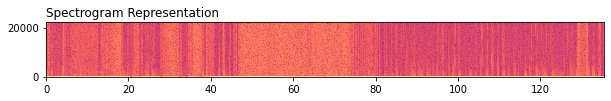

In [56]:
%matplotlib inline

rate = 44100
fft_size = 512

# perform a short-time Fourier transform on the data
frequencies, times, Zxx = signal.stft(S["ch2"], 
                                      rate, 
                                      nfft=fft_size)

spectrogram = np.log(np.abs(Zxx))

plt.figure(figsize=(10, 1))
plt.pcolormesh(times, frequencies, spectrogram, cmap='magma')
plt.title("Spectrogram Representation", loc="left")
plt.show()
plt.close()

In [57]:
# if(save):
#     print(workingDir+os.sep+titleBar+".wav")

#     signal_to_wav((out_data).astype('int'), 
#                   workingDir+os.sep+titleBar+".wav", 
#                   playback_rate)

playback_rate = 11000
IPython.display.Audio(S["ch3"], rate=playback_rate)

# playback_rate = 10000

# for col in S:
#     if len(col) == 3:
        
#         out_filename = os.path.dirname(meas) + os.sep + os.path.basename(meas)[:-4] + "_" + col + "_audio_" + str(playback_rate) + "Hz.wav"
#         signal_to_wav((10000*(S[col]/S[col].max())).astype('int'),
#                       out_filename,
#                       playback_rate)


NameError: name 'IPython' is not defined